In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk

from nltk.corpus import stopwords

In [3]:
stopwords_eng = stopwords.words("english")

lemmatizer = nltk.WordNetLemmatizer()

In [4]:
imdb_data = pd.read_csv("imdb_top_1000.csv")

In [5]:
imdb_data["Gross"] = imdb_data["Gross"].apply(lambda x: float(x.replace(",", "")) if isinstance(x, str) else x)
imdb_data["Released_Year"] = pd.to_datetime(imdb_data["Released_Year"], format="%Y", errors="coerce")
imdb_data["Runtime"] = imdb_data["Runtime"].apply(lambda x: int(x.split()[0]))
imdb_data["Genre"] = imdb_data["Genre"].apply(lambda x: x.split(", "))

### Preprocessing

In [6]:
imdb_data["Overview_processed"] = imdb_data["Overview"].apply(lambda x: x.lower()).apply(nltk.word_tokenize)
imdb_data["Overview_processed"] = imdb_data["Overview_processed"].apply(lambda x: [word for word in x if word not in stopwords_eng])
imdb_data["Overview_processed"] = imdb_data["Overview_processed"].apply(lambda x: [word for word in x if word.isalnum()])
imdb_data["Overview_processed"] = imdb_data["Overview_processed"].apply(lambda x: [word for word in x if not word.isdigit()])
imdb_data["Overview_processed"] = imdb_data["Overview_processed"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [7]:
imdb_data["Overview_length_words"] = imdb_data["Overview_processed"].apply(len)
imdb_data["Overview_length_chars"] = imdb_data["Overview_processed"].apply(lambda x: sum(len(word) for word in x))

9. Director and Actor Impact Analysis:
- Rank directors and actors by average IMDB rating, votes, or gross.
- Build a network graph of collaborations (e.g., directors linked to frequent actors).

In [10]:
director_data = imdb_data.dropna(subset=["Gross", "Director", "IMDB_Rating", "No_of_Votes"])
len(director_data)

831

In [11]:
director_rating = (director_data.groupby("Director")["IMDB_Rating"].mean().reset_index().sort_values(by="IMDB_Rating", ascending=False))
director_rating.head(5)

Director  IMDB_Rating
124      Frank Darabont         8.95
165      Irvin Kershner         8.70
250      Lana Wachowski         8.70
118  Fernando Meirelles         8.60
368     Roberto Benigni         8.60

In [12]:
director_votes = (director_data.groupby("Director")["No_of_Votes"].mean().reset_index().sort_values(by="No_of_Votes", ascending=False))
director_votes.head(5)

Director  No_of_Votes
124     Frank Darabont  1745452.000
250     Lana Wachowski  1676426.000
72   Christopher Nolan  1447293.125
139       George Lucas  1231473.000
335      Peter Jackson  1229715.800

In [13]:
director_gross = (director_data.groupby("Director")["Gross"].sum().reset_index().sort_values(by="Gross", ascending=False))
director_gross.head(5)

Director         Gross
408   Steven Spielberg  2.478133e+09
30       Anthony Russo  2.205039e+09
72   Christopher Nolan  1.937454e+09
173      James Cameron  1.748237e+09
335      Peter Jackson  1.597312e+09

In [15]:
actor_cols = ["Star1", "Star2", "Star3", "Star4"]
actors_long = imdb_data.melt(
    id_vars=["Series_Title", "Director", "Gross", "No_of_Votes", "IMDB_Rating"], 
    value_vars=actor_cols,
    var_name="Actor_Position",
    value_name="Actor"
)

In [16]:
actor_gross = (
    actors_long.groupby("Actor")["Gross"]
    .sum()
    .reset_index()
    .sort_values(by="Gross", ascending=False)
)
actor_gross.head()

Actor         Gross
2137  Robert Downey Jr.  3.129073e+09
2498          Tom Hanks  2.903565e+09
427         Chris Evans  2.339664e+09
1205          Joe Russo  2.205039e+09
1655       Mark Ruffalo  2.058396e+09

In [24]:
actor_rating = (
    actors_long.groupby("Actor")["IMDB_Rating"]
    .mean()
    .reset_index()
    .sort_values(by="IMDB_Rating", ascending=False)
)
actor_rating.head()

Actor  IMDB_Rating
2640    William Sadler          9.3
278         Bob Gunton          9.3
2        Aaron Eckhart          9.0
368   Caroline Goodall          8.9
1264     John Travolta          8.9

In [26]:
actor_votes = (
    actors_long.groupby("Actor")["No_of_Votes"]
    .mean()
    .reset_index()
    .sort_values(by="No_of_Votes", ascending=False)
)
actor_votes.head()

Actor  No_of_Votes
278       Bob Gunton    2343110.0
2640  William Sadler    2343110.0
2      Aaron Eckhart    2303232.0
680      Elliot Page    2067042.0
2689    Zach Grenier    1854740.0

In [30]:

import networkx as nx

In [31]:
#initialize networtk
G = nx.Graph()

In [32]:
#build the network of collaborations
for i, row in imdb_data.iterrows():
    director = row["Director"]
    star1 = row["Star1"]
    star2 = row["Star2"]
    star3 = row["Star3"]
    star4 = row["Star4"]
    
    G.add_node(director, type="director")
    G.add_node(star1, type="actor")
    G.add_node(star2, type="actor")
    G.add_node(star3, type="actor")
    G.add_node(star4, type="actor")
    
    G.add_edge(director, star1)
    G.add_edge(director, star2)
    G.add_edge(director, star3)
    G.add_edge(director, star4)
    
    G.add_edge(star1, star2)
    G.add_edge(star1, star3)
    G.add_edge(star1, star4)
    
    G.add_edge(star2, star3)
    G.add_edge(star2, star4)
    
    G.add_edge(star3, star4)

In [33]:
directors = [n for n, attributes in G.nodes(data=True) if attributes["type"] == "director"]
actors = [n for n, attributes in G.nodes(data=True) if attributes["type"] == "actor"]

color_map = ["lightcoral" if n in directors else "skyblue" for n in G.nodes()]

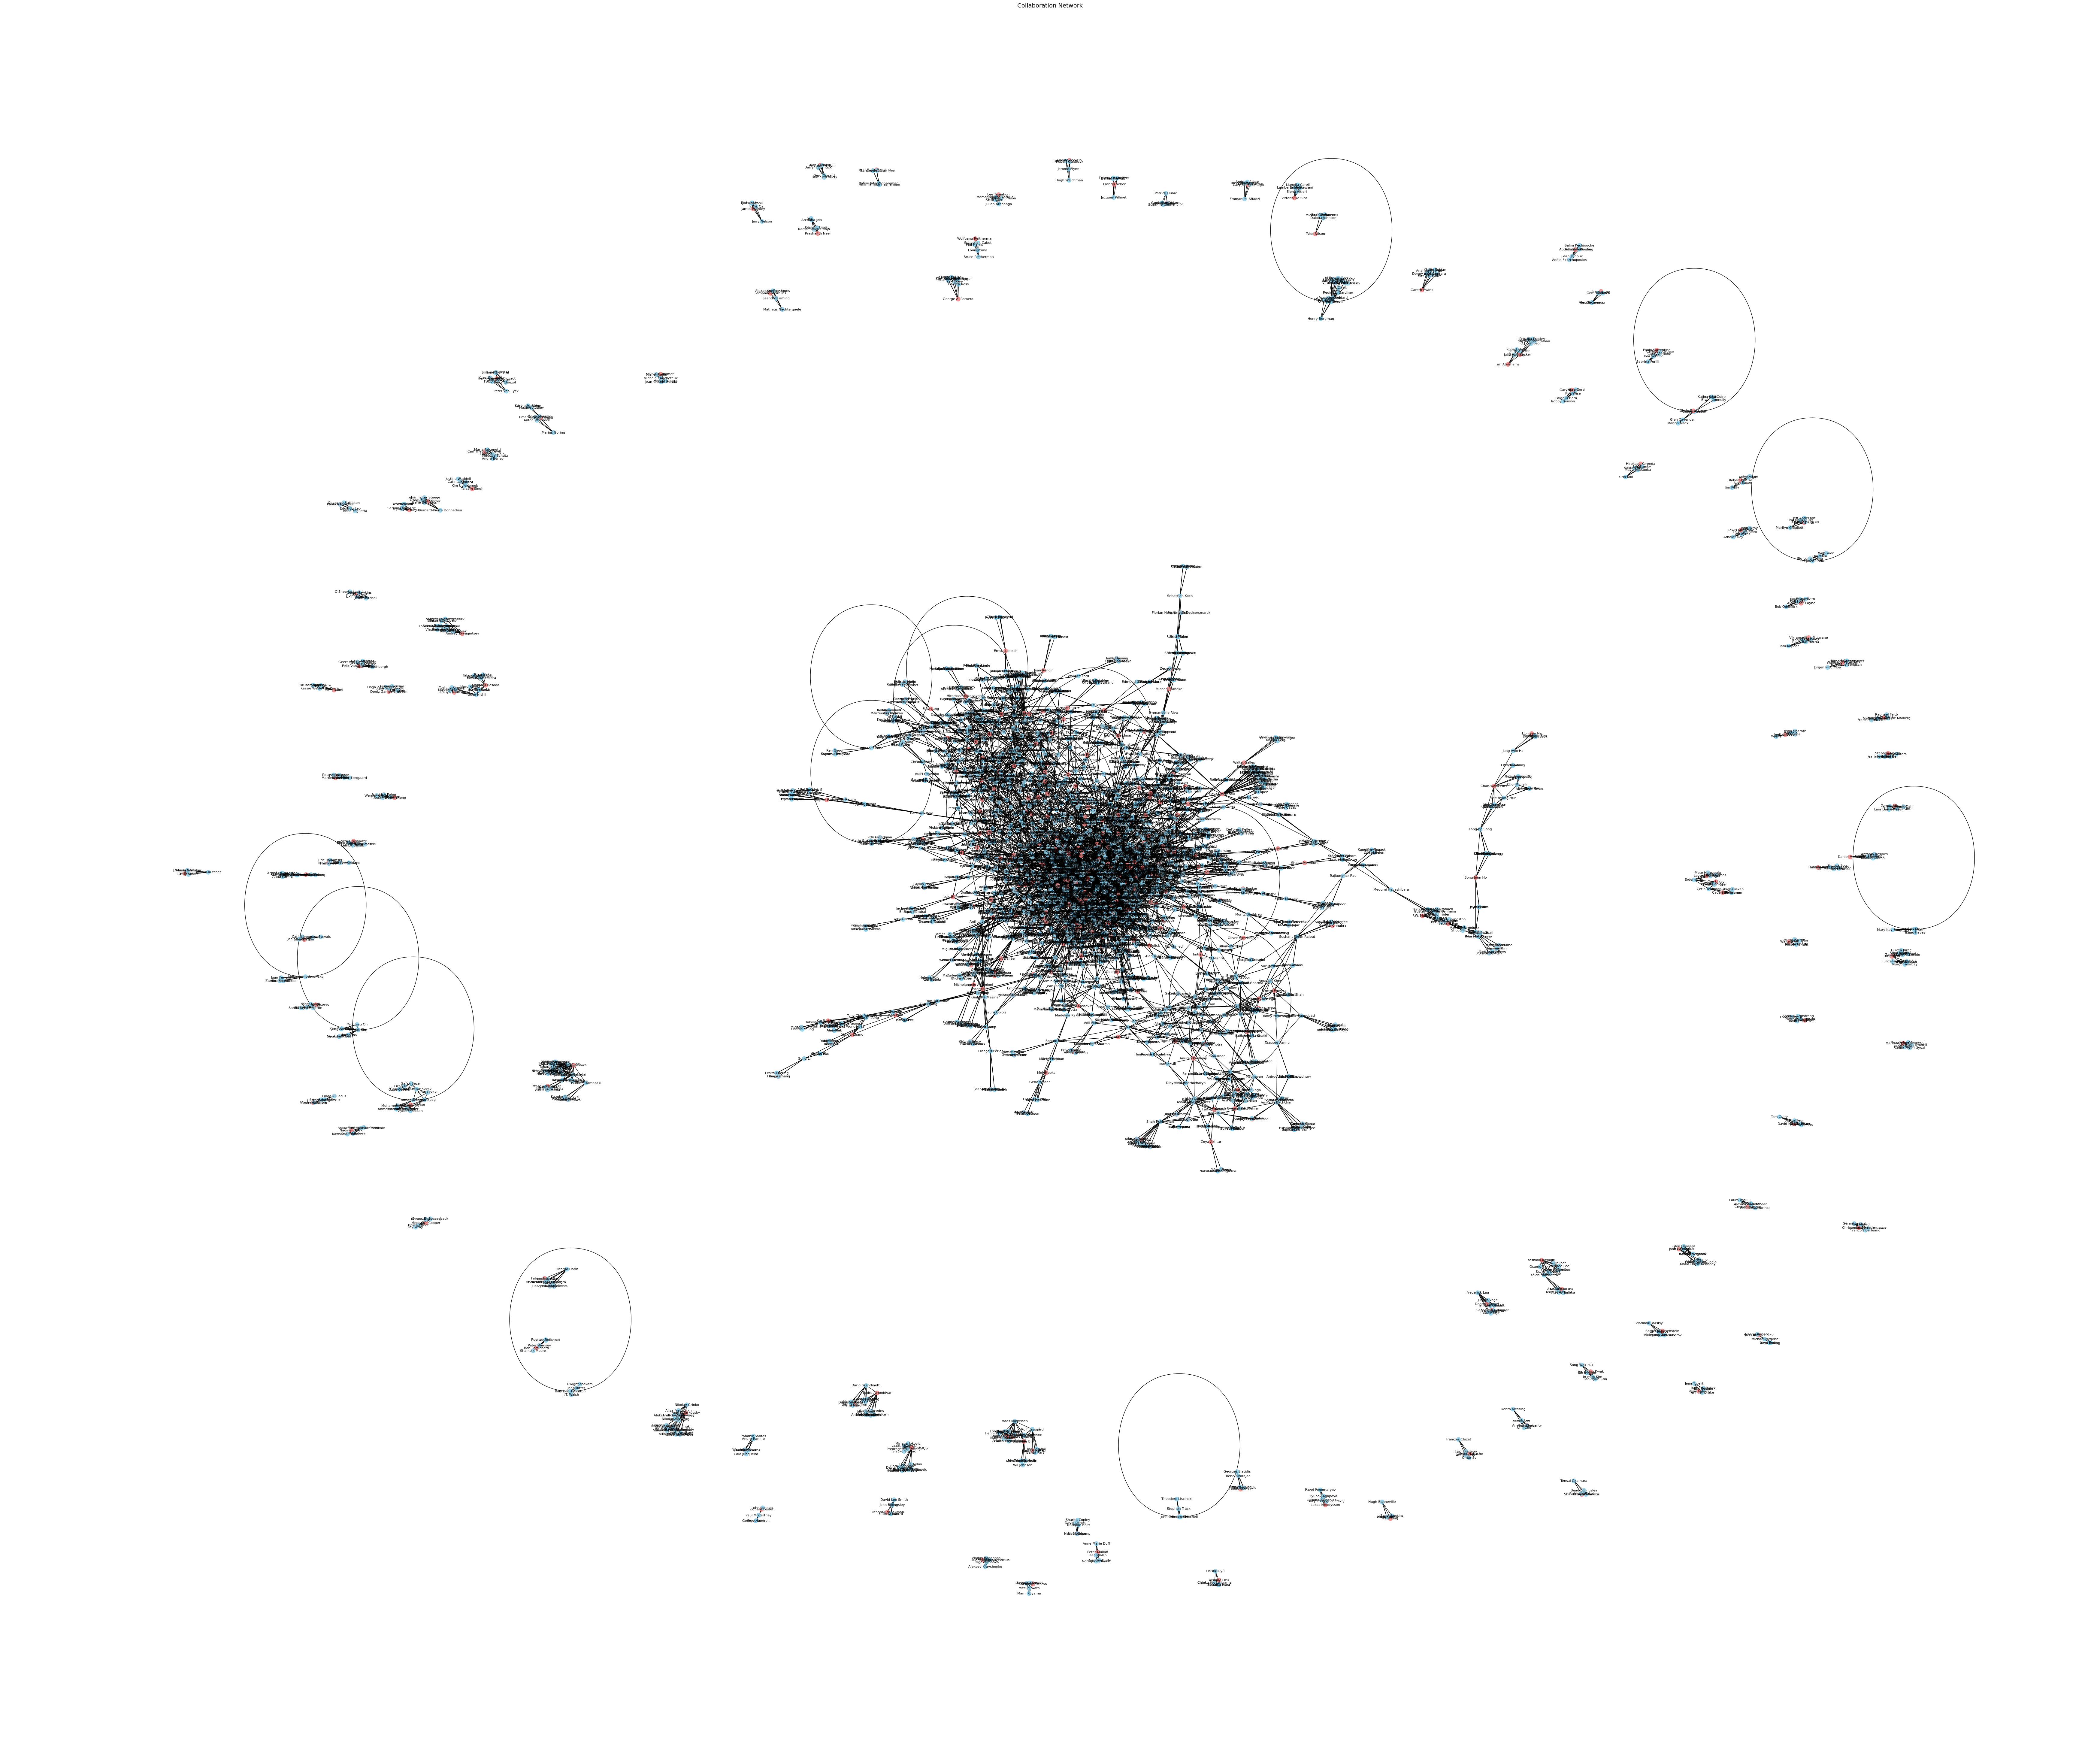

In [34]:
plt.figure(figsize=(90, 75))
pos = nx.spring_layout(G=G)
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=100, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=1)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Collaboration Network", fontsize=14)
plt.axis("off")
plt.show()

10. Topic Modeling on Overviews:
o Use LDA or BERTopic to discover common movie themes (e.g., “romance”, “sci-fi adventure”).
o Track how topics change across decades.

Tried BERTopic for both preproccessed and original overview text for topic modeling. Unprocessed data seemed to give better results

In [1]:
from bertopic import BERTopic
topic_mooldel = BERTopic(embedding_model="all-MiniLM-L6-v2")


C:\Users\eetu\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
def join_ov(text):
    return " ".join(text)

In [11]:
cleaned_overviews = imdb_data["Overview_processed"].apply(join_ov)

In [10]:
imdb_data["processed_overview_string"] = cleaned_overviews
imdb_data.head()

Poster_Link  \
0  https://m.media-amazon.com/images/M/MV5BMDFkYT...   
1  https://m.media-amazon.com/images/M/MV5BM2MyNj...   
2  https://m.media-amazon.com/images/M/MV5BMTMxNT...   
3  https://m.media-amazon.com/images/M/MV5BMWMwMG...   
4  https://m.media-amazon.com/images/M/MV5BMWU4N2...   

               Series_Title Released_Year Certificate  Runtime  \
0  The Shawshank Redemption    1994-01-01           A      142   
1             The Godfather    1972-01-01           A      175   
2           The Dark Knight    2008-01-01          UA      152   
3    The Godfather: Part II    1974-01-01           A      202   
4              12 Angry Men    1957-01-01           U       96   

                    Genre  IMDB_Rating  \
0                 [Drama]          9.3   
1          [Crime, Drama]          9.2   
2  [Action, Crime, Drama]          9.0   
3          [Crime, Drama]          9.0   
4          [Crime, Drama]          9.0   

                                            Overview  Meta_score  \
0  Two imprisoned men bond over a number of years...        80.0   
1  An organized crime dynasty's aging patriarch t...       100.0   
2  When the menace known as the Joker wreaks havo...        84.0   
3  The early life and career of Vito Corleone in ...        90.0   
4  A jury holdout attempts to prevent a miscarria...        96.0   

               Director           Star1           Star2          Star3  \
0        Frank Darabont     Tim Robbins  Morgan Freeman     Bob Gunton   
1  Francis Ford Coppola   Marlon Brando       Al Pacino     James Caan   
2     Christopher Nolan  Christian Bale    Heath Ledger  Aaron Eckhart   
3  Francis Ford Coppola       Al Pacino  Robert De Niro  Robert Duvall   
4          Sidney Lumet     Henry Fonda     Lee J. Cobb  Martin Balsam   

            Star4  No_of_Votes        Gross  \
0  William Sadler      2343110   28341469.0   
1    Diane Keaton      1620367  134966411.0   
2   Michael Caine      2303232  534858444.0   
3    Diane Keaton      1129952   57300000.0   
4    John Fiedler       689845    4360000.0   

                                  Overview_processed  Overview_length_words  \
0  [two, imprisoned, men, bond, number, year, fin...                     13   
1  [organized, crime, dynasty, aging, patriarch, ...                     11   
2  [menace, known, joker, wreaks, havoc, chaos, p...                     19   
3  [early, life, career, vito, corleone, 1920s, n...                     18   
4  [jury, holdout, attempt, prevent, miscarriage,...                     10   

   Overview_length_chars                          processed_overview_string  
0                     77  two imprisoned men bond number year finding so...  
1                     79  organized crime dynasty aging patriarch transf...  
2                    117  menace known joker wreaks havoc chaos people g...  
3                    101  early life career vito corleone 1920s new york...  
4                     77  jury holdout attempt prevent miscarriage justi...

In [12]:
topics, probs = topic_mooldel.fit_transform(cleaned_overviews)

In [13]:
topic_mooldel.get_topic_info()

Topic  Count                              Name  \
0      -1    531            -1_life_young_man_find   
1       0     85          0_love_friend_life_woman   
2       1     64    1_murder_detective_lawyer_case   
3       2     50   2_police_cop_corruption_officer   
4       3     33         3_space_earth_planet_crew   
5       4     33              4_german_war_ii_nazi   
6       5     31  5_daughter_father_missing_mother   
7       6     22       6_father_brother_son_family   
8       7     22     7_school_teacher_high_student   
9       8     21      8_dragon_magical_young_quest   
10      9     20    9_outlaw_american_bandit_train   
11     10     17         10_actor_movie_star_faded   
12     11     17   11_samurai_crafty_ronin_warlord   
13     12     17       12_band_singer_tour_pianist   
14     13     13    13_soldier_enemy_conflict_side   
15     14     13      14_universe_rebel_luke_darth   
16     15     11           15_prison_men_guard_two   

                                       Representation  \
0   [life, young, man, find, new, story, family, w...   
1   [love, friend, life, woman, young, find, meet,...   
2   [murder, detective, lawyer, case, accused, wif...   
3   [police, cop, corruption, officer, agent, unde...   
4   [space, earth, planet, crew, astronaut, alien,...   
5   [german, war, ii, nazi, world, jewish, camp, a...   
6   [daughter, father, missing, mother, child, man...   
7   [father, brother, son, family, younger, boy, s...   
8   [school, teacher, high, student, boy, boarding...   
9   [dragon, magical, young, quest, baggins, bilbo...   
10  [outlaw, american, bandit, train, missouri, no...   
11  [actor, movie, star, faded, director, hollywoo...   
12  [samurai, crafty, ronin, warlord, china, sword...   
13  [band, singer, tour, pianist, legendary, age, ...   
14  [soldier, enemy, conflict, side, behind, ivo, ...   
15  [universe, rebel, luke, darth, vader, galaxy, ...   
16  [prison, men, guard, two, escape, prisoner, im...   

                                  Representative_Docs  
0   [two violent young men take mother father son ...  
1   [poor yet passionate young man fall love rich ...  
2   [police detective fall love woman whose murder...  
3   [undercover cop mole police attempt identify i...  
4   [alien land tell people earth must live peacef...  
5   [france world war ii plan assassinate nazi lea...  
6   [turkish man travel istanbul find daughter fat...  
7   [two brother struggle maintain strict father f...  
8   [teenage boy expelled school fighting arrives ...  
9   [dorothy gale swept away farm kansa magical la...  
10  [town marshal despite disagreement newlywed br...  
11  [egomaniacal film star develops relationship y...  
12  [vagabond swordsman aided beautiful ninja girl...  
13  [chronicle country music legend johnny cash li...  
14  [war rage abkhazia breakaway region georgia es...  
15  [daring mission rescue han solo jabba hutt reb...  
16  [alcatraz secure prison time believed one ever...

In [80]:
topic_mooldel.get_topic(0)

[('friend', 0.058389990498933196),
 ('young', 0.04064628942818861),
 ('life', 0.04011839859414403),
 ('meet', 0.032600514855849826),
 ('love', 0.032521351449106596),
 ('woman', 0.030597904635578273),
 ('find', 0.027678670189442457),
 ('friendship', 0.026540680265860872),
 ('two', 0.025399083401166412),
 ('boy', 0.025219550137097962)]

In [19]:
topic_mooldel_unprocessed = BERTopic(embedding_model="all-MiniLM-L6-v2")

In [20]:
topics_no_preprocess, probs_no_preprocess = topic_mooldel_unprocessed.fit_transform(imdb_data["Overview"])

In [21]:
topic_mooldel_unprocessed.get_topic_info()

Topic  Count                            Name  \
0      -1    497               -1_the_to_and_his   
1       0     71              0_war_the_world_of   
2       1     54          1_love_their_with_each   
3       2     43      2_murder_detective_case_of   
4       3     37                 3_man_he_his_of   
5       4     34   4_school_boy_teacher_students   
6       5     33   5_cop_agent_police_undercover   
7       6     29         6_and_singer_of_herself   
8       7     29        7_her_girl_housewife_the   
9       8     27               8_the_of_king_his   
10      9     19               9_lives_in_and_of   
11     10     19           10_space_earth_on_the   
12     11     17    11_must_to_universe_avengers   
13     12     15     12_family_father_2013_while   
14     13     14    13_boxer_boxing_champion_his   
15     14     14   14_her_woman_missing_pregnant   
16     15     13  15_gangster_prohibition_in_his   
17     16     13    16_outlaw_outlaws_bandit_the   
18     17     12         17_prison_men_man_crime   
19     18     10       18_harry_dark_destroy_the   

                                       Representation  \
0       [the, to, and, his, of, in, is, an, with, on]   
1   [war, the, world, of, ii, during, german, sold...   
2   [love, their, with, each, and, in, two, young,...   
3   [murder, detective, case, of, in, is, an, lawy...   
4   [man, he, his, of, life, to, the, after, accid...   
5   [school, boy, teacher, students, the, to, of, ...   
6   [cop, agent, police, undercover, the, to, and,...   
7   [and, singer, of, herself, age, career, broadw...   
8   [her, girl, housewife, the, in, world, she, wi...   
9   [the, of, king, his, samurai, and, in, to, bri...   
10  [lives, in, and, of, the, angeles, los, drug, ...   
11  [space, earth, on, the, to, after, astronauts,...   
12  [must, to, universe, avengers, mutant, and, to...   
13  [family, father, 2013, while, of, the, streets...   
14  [boxer, boxing, champion, his, in, former, bro...   
15  [her, woman, missing, pregnant, search, find, ...   
16  [gangster, prohibition, in, his, era, the, mob...   
17  [outlaw, outlaws, bandit, the, bounty, train, ...   
18  [prison, men, man, crime, two, escape, to, gua...   
19  [harry, dark, destroy, the, lord, voldemort, h...   

                                  Representative_Docs  
0   [To save her father from death in the army, a ...  
1   [In Nazi-occupied France during World War II, ...  
2   [Three inseparable childhood friends are just ...  
3   [A police detective falls in love with the wom...  
4   [After a famous author is rescued from a car c...  
5   [An emotive journey of a former school teacher...  
6   [A tough-as-nails cop teams up with an underco...  
7   [The story of the life and career of the legen...  
8   [A high-school girl named Makoto acquires the ...  
9   [In Medieval Japan, an elderly warlord retires...  
10  [The rap group NWA emerges from the mean stree...  
11  [An alien on Earth loses the only device he ca...  
12  [Foul-mouthed mutant mercenary Wade Wilson (a....  
13  [A family heads to an isolated hotel for the w...  
14  [A small-time boxer gets a supremely rare chan...  
15  [After her werewolf lover unexpectedly dies in...  
16  [A former Prohibition-era Jewish gangster retu...  
17  [A small-time rancher agrees to hold a capture...  
18  [A man befriends a fellow criminal as the two ...  
19  [As Harry, Ron, and Hermione race against time...

In [22]:
topic_mooldel_unprocessed.get_representative_docs(0)

["In Nazi-occupied France during World War II, a plan to assassinate Nazi leaders by a group of Jewish U.S. soldiers coincides with a theatre owner's vengeful plans for the same.",
 'Allied prisoners of war plan for several hundred of their number to escape from a German camp during World War II.',
 'Allied soldiers from Belgium, the British Empire, and France are surrounded by the German Army and evacuated during a fierce battle in World War II.']

In [24]:
imdb_data["BERTopic"] = topics_no_preprocess
imdb_data.head(20)

Poster_Link  \
0   https://m.media-amazon.com/images/M/MV5BMDFkYT...   
1   https://m.media-amazon.com/images/M/MV5BM2MyNj...   
2   https://m.media-amazon.com/images/M/MV5BMTMxNT...   
3   https://m.media-amazon.com/images/M/MV5BMWMwMG...   
4   https://m.media-amazon.com/images/M/MV5BMWU4N2...   
5   https://m.media-amazon.com/images/M/MV5BNzA5ZD...   
6   https://m.media-amazon.com/images/M/MV5BNGNhMD...   
7   https://m.media-amazon.com/images/M/MV5BNDE4OT...   
8   https://m.media-amazon.com/images/M/MV5BMjAxMz...   
9   https://m.media-amazon.com/images/M/MV5BMmEzNT...   
10  https://m.media-amazon.com/images/M/MV5BN2EyZj...   
11  https://m.media-amazon.com/images/M/MV5BNWIwOD...   
12  https://m.media-amazon.com/images/M/MV5BOTQ5ND...   
13  https://m.media-amazon.com/images/M/MV5BZGMxZT...   
14  https://m.media-amazon.com/images/M/MV5BNzQzOT...   
15  https://m.media-amazon.com/images/M/MV5BY2NkZj...   
16  https://m.media-amazon.com/images/M/MV5BYmU1ND...   
17  https://m.media-amazon.com/images/M/MV5BZjA0OW...   
18  https://m.media-amazon.com/images/M/MV5BNjViNW...   
19  https://m.media-amazon.com/images/M/MV5BYWZjMj...   

                                         Series_Title Released_Year  \
0                            The Shawshank Redemption    1994-01-01   
1                                       The Godfather    1972-01-01   
2                                     The Dark Knight    2008-01-01   
3                              The Godfather: Part II    1974-01-01   
4                                        12 Angry Men    1957-01-01   
5       The Lord of the Rings: The Return of the King    2003-01-01   
6                                        Pulp Fiction    1994-01-01   
7                                    Schindler's List    1993-01-01   
8                                           Inception    2010-01-01   
9                                          Fight Club    1999-01-01   
10  The Lord of the Rings: The Fellowship of the Ring    2001-01-01   
11                                       Forrest Gump    1994-01-01   
12                    Il buono, il brutto, il cattivo    1966-01-01   
13              The Lord of the Rings: The Two Towers    2002-01-01   
14                                         The Matrix    1999-01-01   
15                                         Goodfellas    1990-01-01   
16     Star Wars: Episode V - The Empire Strikes Back    1980-01-01   
17                    One Flew Over the Cuckoo's Nest    1975-01-01   
18                                           Hamilton    2020-01-01   
19                                       Gisaengchung    2019-01-01   

   Certificate  Runtime                         Genre  IMDB_Rating  \
0            A      142                       [Drama]          9.3   
1            A      175                [Crime, Drama]          9.2   
2           UA      152        [Action, Crime, Drama]          9.0   
3            A      202                [Crime, Drama]          9.0   
4            U       96                [Crime, Drama]          9.0   
5            U      201    [Action, Adventure, Drama]          8.9   
6            A      154                [Crime, Drama]          8.9   
7            A      195   [Biography, Drama, History]          8.9   
8           UA      148   [Action, Adventure, Sci-Fi]          8.8   
9            A      139                       [Drama]          8.8   
10           U      178    [Action, Adventure, Drama]          8.8   
11          UA      142              [Drama, Romance]          8.8   
12           A      161                     [Western]          8.8   
13          UA      179    [Action, Adventure, Drama]          8.7   
14           A      136              [Action, Sci-Fi]          8.7   
15           A      146     [Biography, Crime, Drama]          8.7   
16          UA      124  [Action, Adventure, Fantasy]          8.7   
17           A      133                       [Drama]          8.7   
18       PG-13      16

In [25]:
imdb_data["Released_Decade"] = (imdb_data["Released_Year"].dt.year // 10) * 10
# filter out outliers with topic = -1
topic_data = imdb_data[imdb_data["BERTopic"] != -1].copy()
topic_counts = topic_data.groupby(["Released_Decade", "BERTopic"]).size().reset_index(name="Count")
topic_pivot = topic_counts.pivot(index="Released_Decade", columns="BERTopic", values="Count").fillna(0)

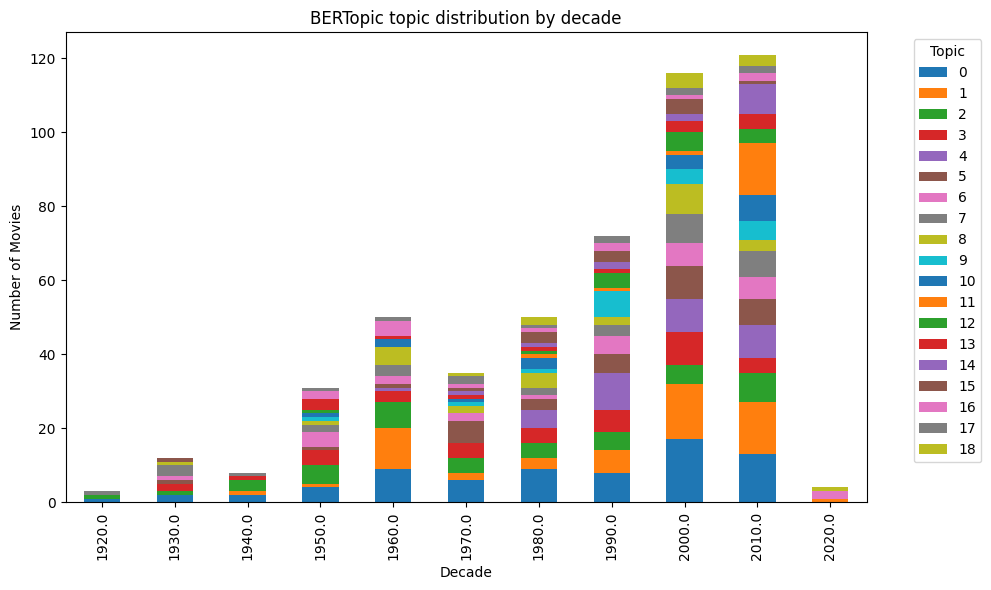

In [26]:
topic_pivot.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("BERTopic topic distribution by decade")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


11. Meta_score vs. IMDB Rating Discrepancy:
o Compare critic (Meta_score) vs. audience (IMDB_Rating).
o Identify movies where critics and audiences strongly disagree.

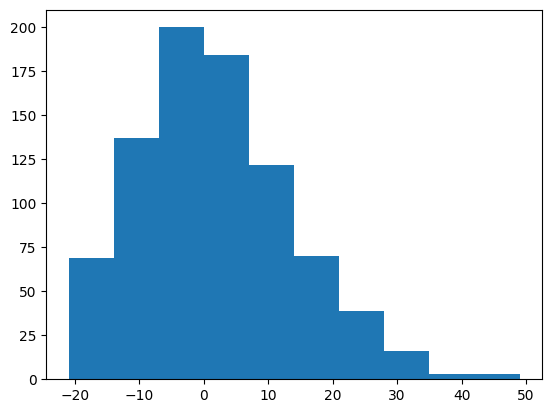

In [28]:
# scaling rating to [0-100] to match meta score and calculating the difference for each movie
imdb_data["Scaled_IMDB_Rating"] = imdb_data["IMDB_Rating"] * 10
imdb_data["Rating_Difference"] = imdb_data["Scaled_IMDB_Rating"] - imdb_data["Meta_score"]
plt.hist(imdb_data["Rating_Difference"])
plt.show()

In [29]:
# LOW METASCORE HIGH RATING
imdb_data.nlargest(3, "Rating_Difference")

Poster_Link          Series_Title  \
788  https://m.media-amazon.com/images/M/MV5BYzEyNz...              I Am Sam   
356  https://m.media-amazon.com/images/M/MV5BYmI1OD...        Tropa de Elite   
942  https://m.media-amazon.com/images/M/MV5BODNiZm...  The Butterfly Effect   

    Released_Year Certificate  Runtime                      Genre  \
788    2001-01-01       PG-13      132                    [Drama]   
356    2007-01-01           R      115     [Action, Crime, Drama]   
942    2004-01-01           U      113  [Drama, Sci-Fi, Thriller]   

     IMDB_Rating                                           Overview  \
788          7.7  A mentally handicapped man fights for custody ...   
356          8.0  In 1997 Rio de Janeiro, Captain Nascimento has...   
942          7.6  Evan Treborn suffers blackouts during signific...   

     Meta_score       Director  ...           Star4 No_of_Votes       Gross  \
788        28.0  Jessie Nelson  ...    Dianne Wiest      142863  40311852.0   
356        33.0   José Padilha  ...   Milhem Cortaz       98097      8060.0   
942        30.0     Eric Bress  ...  Melora Walters      451479  57938693.0   

                                    Overview_processed  Overview_length_words  \
788  [mentally, handicapped, man, fight, custody, d...                     12   
356  [rio, de, janeiro, captain, nascimento, find, ...                     15   
942  [evan, treborn, suffers, blackout, significant...                     19   

     Overview_length_chars Released_Decade  BERTopic  Scaled_IMDB_Rating  \
788                     75          2000.0        -1                77.0   
356                     88          2000.0        15                80.0   
942                    114          2000.0        -1                76.0   

     Rating_Difference  
788               49.0  
356               47.0  
942               46.0  

[3 rows x 23 columns]

In [30]:
# LOW RATING HIGH METASCORE
imdb_data.nsmallest(3, "Rating_Difference")

Poster_Link    Series_Title  \
491  https://m.media-amazon.com/images/M/MV5BMTYzND...         Boyhood   
559  https://m.media-amazon.com/images/M/MV5BYTc1NG...       Notorious   
423  https://m.media-amazon.com/images/M/MV5BODFlYz...  Il conformista   

    Released_Year Certificate  Runtime                        Genre  \
491    2014-01-01           A      165                      [Drama]   
559    1946-01-01           U      102  [Drama, Film-Noir, Romance]   
423    1970-01-01          UA      113                      [Drama]   

     IMDB_Rating                                           Overview  \
491          7.9  The life of Mason, from early childhood to his...   
559          7.9  A woman is asked to spy on a group of Nazi fri...   
423          8.0  A weak-willed Italian man becomes a fascist fl...   

     Meta_score             Director  ...          Star4 No_of_Votes  \
491       100.0    Richard Linklater  ...   Elijah Smith      335533   
559       100.0     Alfred Hitchcock  ...  Louis Calhern       92306   
423       100.0  Bernardo Bertolucci  ...  Enzo Tarascio       27067   

          Gross                                 Overview_processed  \
491  25379975.0  [life, mason, early, childhood, arrival, college]   
559  10464000.0  [woman, asked, spy, group, nazi, friend, south...   
423    541940.0  [italian, man, becomes, fascist, flunky, go, a...   

     Overview_length_words  Overview_length_chars Released_Decade  BERTopic  \
491                      6                     37          2010.0         4   
559                     11                     55          1940.0         0   
423                     13                     86          1970.0        -1   

     Scaled_IMDB_Rating  Rating_Difference  
491                79.0              -21.0  
559                79.0              -21.0  
423                80.0              -20.0  

[3 rows x 23 columns]